In [ ]:
import os
import random
import pandas as pd
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class UCF101Dataset(Dataset):
    def __init__(self, csv_file, video_base_path, selected_labels=None, 
                 num_frames_per_video=16, resize=(112, 112), transform=None):
        
        self.video_base_path = video_base_path
        self.num_frames_per_video = num_frames_per_video
        self.resize = resize
        
        # Load CSV and filter by selected labels if provided
        self.df = pd.read_csv(csv_file)
        if selected_labels is not None:
            self.df = self.df[self.df['label'].isin(selected_labels)].reset_index(drop=True)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def extract_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
            return None

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames < self.num_frames_per_video:
            print(f"Warning: Video {video_path} has only {total_frames} frames, less than {self.num_frames_per_video}")
            cap.release()
            return None

        frame_indices = np.linspace(0, total_frames - 1, self.num_frames_per_video, dtype=int)
        frames = []

        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                print(f"Warning: Could not read frame {idx} from {video_path}")
                cap.release()
                return None
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, self.resize)
            frames.append(frame)
        cap.release()

        frames_np = np.stack(frames).astype(np.float32) / 255.0  # shape (num_frames, H, W, C)

        # Convert to tensor and permute to (num_frames, C, H, W)
        frames_tensor = torch.from_numpy(frames_np).permute(0, 3, 1, 2)

        if self.transform:
            frames_tensor = self.transform(frames_tensor)
        
        return frames_tensor
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        clip_rel_path = row['clip_path'].lstrip("/")
        video_path = os.path.join(self.video_base_path, clip_rel_path)
        
        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Video file not found: {video_path}")
        
        frames = self.extract_frames(video_path)
        if frames is None:
            # If frame extraction failed, try the next video (simple fallback)
            new_idx = (idx + 1) % len(self)
            return self.__getitem__(new_idx)
        
        label = row['label']
        
        return frames, label


In [ ]:
from torchvision import transforms

# Optional: normalization transform
transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
# Map string labels to integer indices
label_to_index = {
    'PlayingCello': 0,
    'PlayingDhol': 1,
    'TennisSwing': 2,
    'CricketShot': 3,
    'HorseRiding': 4
}

# Custom wrapper to convert string labels to integer indices
def collate_fn(batch):
    frames, labels = zip(*batch)
    frames = torch.stack(frames)
    labels_in = torch.tensor([label_to_index[label] for label in labels], dtype=torch.long)
    return frames, labels_in

# Create training dataset
train_dataset = UCF101Dataset(
    csv_file="train_updated.csv",
    video_base_path="data",
    selected_labels=['PlayingCello','PlayingDhol','TennisSwing','CricketShot','HorseRiding'],
    num_frames_per_video=16,
    resize=(112, 112),
    transform=transform
)

# Create validation dataset
val_dataset = UCF101Dataset(
    csv_file="val_updated.csv",
    video_base_path="data",
    selected_labels=['PlayingCello','PlayingDhol','TennisSwing','CricketShot','HorseRiding'],
    num_frames_per_video=16,
    resize=(112, 112),
    transform=transform
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to

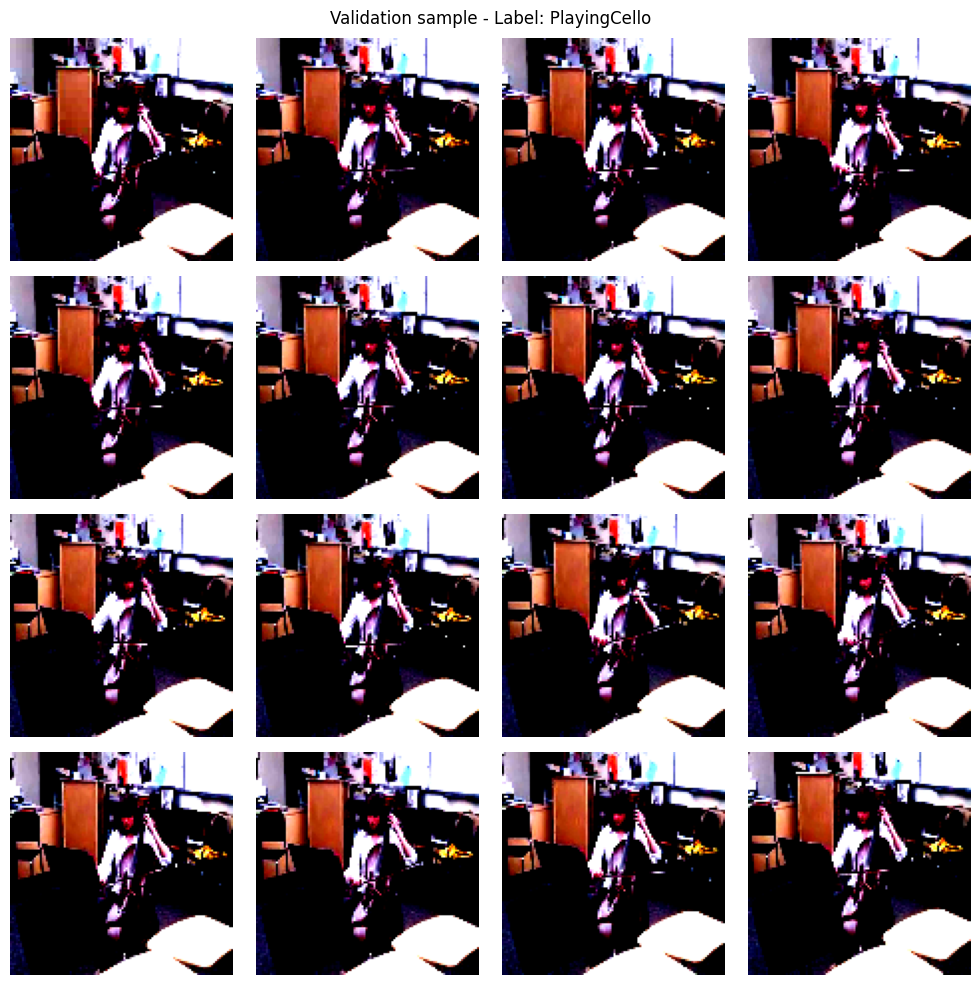

In [4]:
import random
import matplotlib.pyplot as plt
val_index = random.randint(0, len(val_dataset) - 1)
frames_tensor, label = val_dataset[val_index]

# Permute for plotting (from [C, T, H, W] or [T, C, H, W] to [T, H, W, C])
if frames_tensor.shape[0] == 3:
    frames_tensor = frames_tensor.permute(1, 2, 3, 0)
else:
    frames_tensor = frames_tensor.permute(0, 2, 3, 1)

frames_np = frames_tensor.numpy()

# Plot the 16 frames
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(frames_np[i])
    plt.axis("off")
plt.suptitle(f"Validation sample - Label: {label}")
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4782944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5639181].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3241715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2727973].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.221423].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2556726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.238

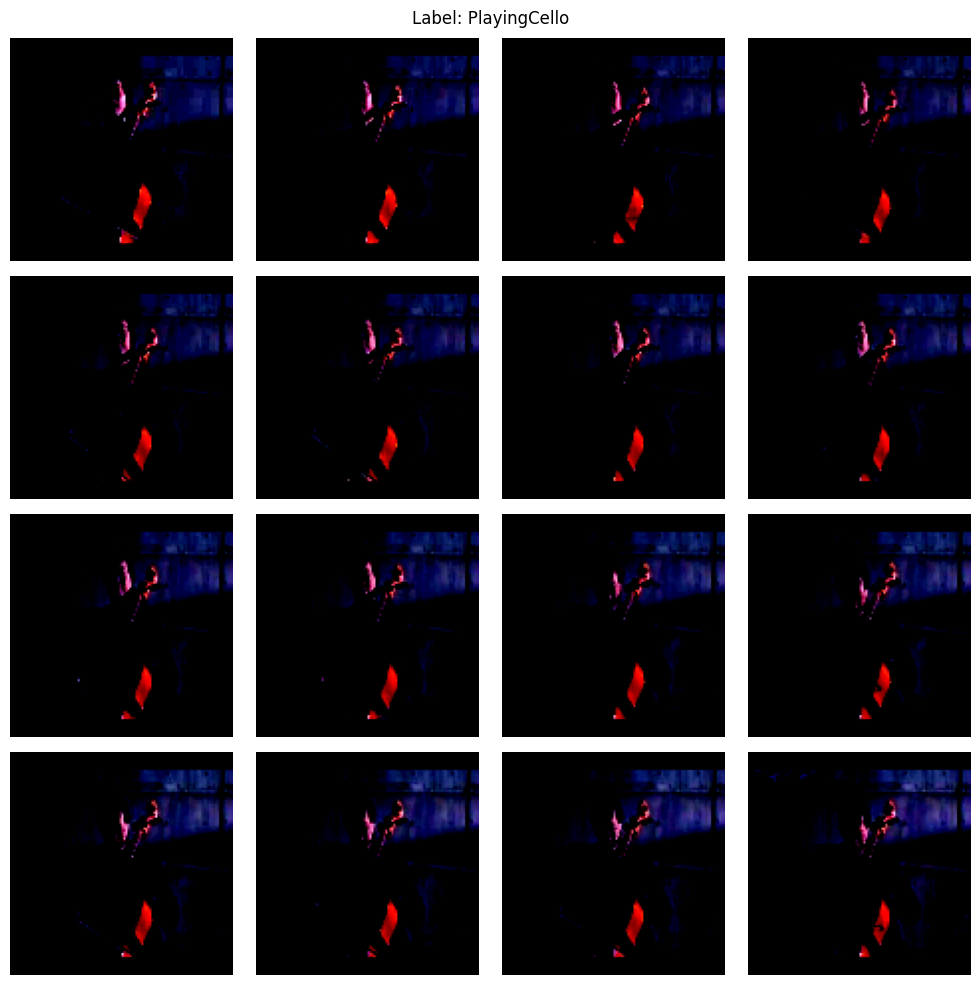

In [5]:
import random
import matplotlib.pyplot as plt
import torch

# Get a random sample from the dataset
index = random.randint(0, len(train_dataset) - 1)
frames_tensor, label = train_dataset[index]  # frames_tensor: [T, C, H, W]

# If frames are in [C, T, H, W], permute back to [T, H, W, C] for plotting
if frames_tensor.shape[0] == 3:
    frames_tensor = frames_tensor.permute(1, 2, 3, 0)  # [T, H, W, C]
else:
    frames_tensor = frames_tensor.permute(0, 2, 3, 1)  # [T, H, W, C]

# Convert to NumPy for plotting
frames_np = frames_tensor.numpy()

# Plot 16 frames
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(frames_tensor[i])
    plt.axis("off")
plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to

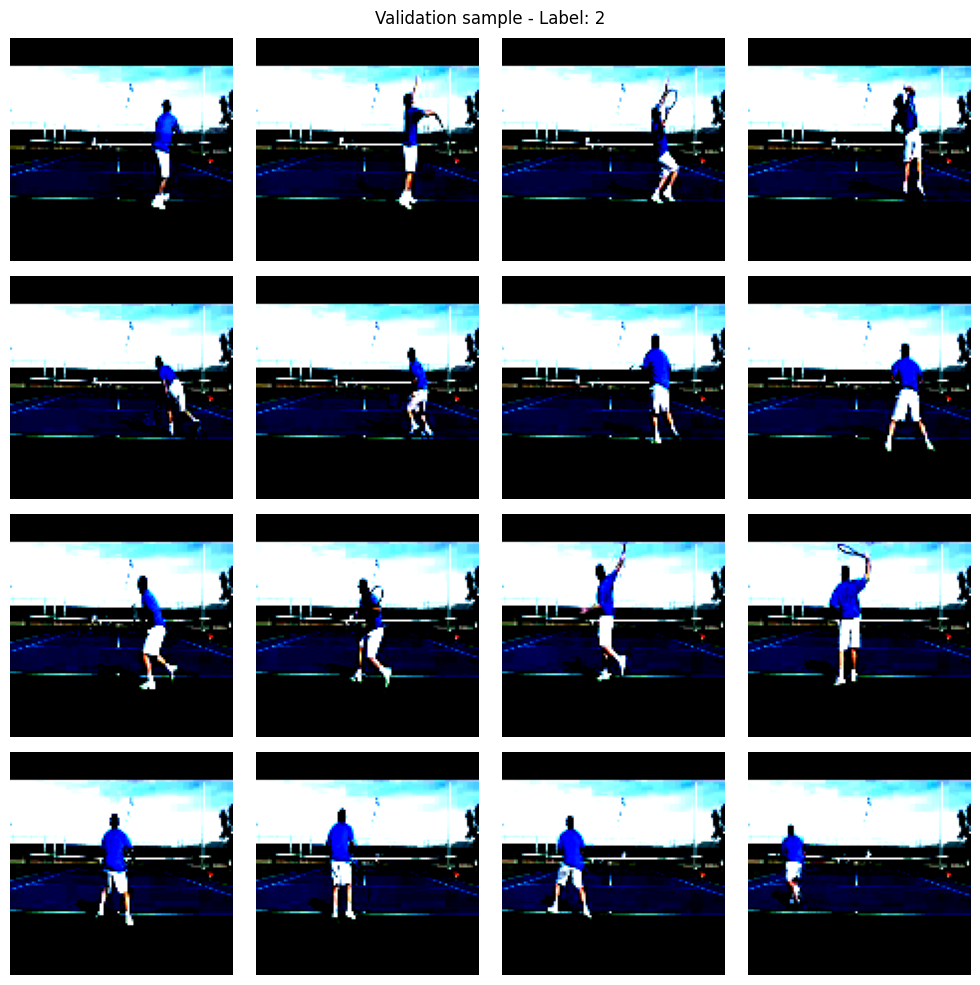

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, collate_fn=collate_fn)

# Example: Visualize one batch from validation loader
for frames_tensor, labels in val_loader:
    # Convert to [B, T, H, W, C] for visualization
    frames_tensor = frames_tensor.permute(0, 1, 3, 4, 2).numpy()  # [B, T, H, W, C]

    # Plot the first video in the batch
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(frames_tensor[0, i])
        plt.axis("off")
    plt.suptitle(f"Validation sample - Label: {labels[0]}")
    plt.tight_layout()
    plt.show()
    break  # visualize only one batch

In [7]:
#Model without SVM and Validation function
import torch
import torch.nn as nn

class C3D(nn.Module):
    def __init__(self, num_classes=101):
        super(C3D, self).__init__()

        self.features = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),

            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),

            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),

            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),

            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        )

        # Dynamically determine the flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 16, 112, 112)
            dummy_output = self.features(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1)
        return self.classifier(x)


In [8]:
if 'labels' not in locals():
	for i, (frames, labels) in enumerate(train_loader):
		break  

print(type(labels), labels)

if 'labels' not in locals():
	for i, (frames, labels) in enumerate(val_loader):
		break  

print(type(labels), labels)


<class 'torch.Tensor'> tensor([2, 2, 2, 2, 2])
<class 'torch.Tensor'> tensor([2, 2, 2, 2, 2])


In [9]:

if 'frames' not in locals():
	for i, (frames, label) in enumerate(train_loader):
		break  

print("Input to model:", frames.shape)

Input to model: torch.Size([5, 16, 3, 112, 112])


In [10]:
def hinge_loss(outputs, targets, margin=1.0):
    """Multi-class hinge loss (SVM-style)."""
    batch_size = outputs.size(0)
    correct_class_scores = outputs[range(batch_size), targets].view(-1, 1)
    margins = torch.clamp(outputs - correct_class_scores + margin, min=0)
    margins[range(batch_size), targets] = 0  # zero out the correct class
    return margins.sum() / batch_size


In [11]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4050 Laptop GPU


In [15]:
import cv2
cap = cv2.VideoCapture('data/train/TennisSwing/v_TennisSwing_g16_c04.avi')
frame_num = 321
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
ret, frame = cap.read()
if not ret:
    print(f"Failed to read frame {frame_num}")

Failed to read frame 321


In [12]:
import torch.optim as optim

num_classes = 5
model = C3D(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # Convert [B, T, C, H, W] to [B, C, T, H, W]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f} - Accuracy: {100 * correct / total:.2f}%")

    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1, 3, 4)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Validation Accuracy: {100 * val_correct / val_total:.2f}%\n")

Epoch 1/5 - Loss: 486.9480 - Accuracy: 18.93%
Validation Accuracy: 20.59%

Epoch 2/5 - Loss: 200.2019 - Accuracy: 19.42%
Validation Accuracy: 20.59%

Epoch 3/5 - Loss: 199.9590 - Accuracy: 18.28%
Validation Accuracy: 20.59%

Epoch 4/5 - Loss: 199.9840 - Accuracy: 17.64%
Validation Accuracy: 19.61%

Epoch 5/5 - Loss: 199.9273 - Accuracy: 18.61%
Validation Accuracy: 19.61%

